In [15]:
import numpy as np
import scipy.integrate as sp
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [130]:
#DEFINITION DES POTENTIELS UTILES
#Remarque: dans tout le code les potentiels sont donnés en Hartree et les distances en rayon de Bohr
def V1(x):
    #puit carré de potentiel
    a=2 #demi-largeur du puit (valeur typique:2)
    V_0 = 5 #Profondeur du puit (valeur typique:5)
    return -V_0/2*(1-np.sign(np.abs(x)-a))
def V2(x):
    #oscillateur harmonique
    a=0.3 #convexité du potentiel (valeur typique:2)
    V_0 = 5 #Profondeur du potentiel (valeur typique:5)
    return V_0*(x*a)**2
def V3(x):
    #potentiel de Lenard-Jones
    x0=10 #abscisse du minimum du potentiel (valeur typique:10)
    V_0 = 5 #Profondeur du potentiel (valeur typique:5)
    return 4*V_0*((x0*2**(-1/6)/x)**12-(x0*2**(-1/6)/x)**6 )
def V4(x):
    #potentiel de Morse
    a=1 #convexité du potentiel (valeur typique:1)
    x0=5 #abscisse du minimum du potentiel (valeur typique:3)
    V_0 = 5 #Profondeur du potentiel (valeur typique:5)
    return V_0*((1-np.exp(-a*(x-x0)))**2)
def V5 (x):
    #puit quadratique
    a=3 #demi-largeur du puit (valeur typique:2)
    V_0 = 5 #Profondeur du puit (valeur typique:5)
    return V_0/2*((x/a)**2-1)*(1-np.sign(np.abs(x)-a))
def V6(x):
    #puit infini de potentiel
    a=1 #demi-largeur du puit (valeur typique:1)
    V_0 = 500 #Hauteur du potentiel >>1 (valeur typique:1000)
    return V_0-V_0/2*(1-np.sign(np.abs(x)-a))

#NORMALISATION DES FONCTIONS D'ONDES
def normalization(psi, x):
    """
    normalise la fonction en entrée:
    x = liste des points en lequels la fonction est évaluée
    psi = liste des valeurs de la fonction en chaque point de x : f(x[i])=psi[i]
    """
    norm = sp.simps(abs(psi)**2,x)
    return psi/np.sqrt(norm)

In [131]:
def numerov(psi_range,x_range,V,E,direction):
    """
    This function applies the numerov scheme on a discretized 1D space represented by x_range, in order to produce an approximate solution of the Schödinger
    equation with the potential V and the energy E.
    
    psi_range = array which will contain the psi_i, with the boundary values already initialised
    x_range = array containing the values of x
    V = function for the potential
    E = Energy to be tested
    direction -> 1 = increasing x ; -1 = decreasing x
    
    return : an array containing the approximate solution psi(x) for each x of x_range"""
    
    #création de variables utiles
    Q = lambda x : 2*(E-V(x))
    h = x_range[1]-x_range[0]  
    psi_out = psi_range.copy()
    
    #réalisation de l'intégration de Numerov
    if direction == 1 :
        for i in range(2,len(psi_range)):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i-1]))*psi_out[i-1]-(1+1/12*h**2*Q(x_range[i-2]))*psi_out[i-2])/(1+1/12*h**2*Q(x_range[i]))
    if direction == -1 :
        for i in range(len(psi_range)-3,-1,-1):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i+1]))*psi_out[i+1]-(1+1/12*h**2*Q(x_range[i+2]))*psi_out[i+2])/(1+1/12*h**2*Q(x_range[i]))
    
    return psi_out

In [132]:
def calculus(x_range,E,V):
    """
    Calcule la fonction d'onde avec la méthode midpoint pour une énergie et un potentiels donnés
    """
    N_x_c=int(len(x_range)/2)
    psi_range=np.zeros(len(x_range))
    psi_range[0] = 0
    psi_range[1] = eps
    psi_range[-1] = 0
    psi_range[-2] = eps
    #découpage des ranges au mid-point
    x_left = x_range.copy()[0:N_x_c+1]
    x_right = x_range.copy()[N_x_c:] 
    
    psi_left = psi_range.copy()[0:N_x_c+1]
    psi_right = psi_range.copy()[N_x_c:]
    
    #réalisation des intégrations de numerov
    psi_left = numerov(psi_left,x_left,V,E,1)
    psi_right = numerov(psi_right,x_right,V,E,-1)
    psi_out = np.concatenate((psi_left[0:-1],psi_right*((psi_left[-1])/(psi_right[0]))))

    return psi_out

In [133]:
def recherche_lin(V,x_range,E_min,E_max,dE,eps,sens,affiche):
    """
    Recherche les énergies propres de l'équation de Schrödinder stationnaire à 1D pour un potentiel V donné 
    par la méthode de minimisation de la divergence des fonctions d'ondes en région asymptotique: 
    - un crible d'énergie linéaire est créé : la liste des energies commence à E_min et finit à E_max, avec un pas de dE
    - pour chaque valeur d'énergie on calcule la fonction d'onde résultante par la méthode numérov (sens=+1 : g/d , sens=-1 : d/g)
    - on évalue le log de la derniène valeur de chaque fonction d'onde résultante
    - on garde les valeurs d'énergies pour lequels on trouve un minimum local de ces valeurs
    Ces énergies sont enfin renvoyées sous formes de liste
    
    V=potentiel
    E_min,E_max = bornes d'energies à tester
    dE= pas entre 2 energies testées 
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    N_E=int((E_max-E_min)/dE+1) # taille de la liste d'énergie
    E_range=np.linspace(E_min,E_max,N_E) #liste des énergies pour lequelles ont calcule la fonction d'onde
    I=[]
    Y_last=[] #liste des dernières valeurs de chaque fonction d'onde 
    Z_last=[] #log de Y_last
    print("RECHERCHE LINEAIRE:")
    for E in tqdm(E_range):
        psi_range = np.zeros(len(x_range))
        if sens==1:
            psi_range[0] = 0
            psi_range[1] = eps
            out=numerov(psi_range,x_range,V,E,1)
            Y_last.append(abs(out[-1]))
            Z_last.append(np.log(abs(out[-1])))

        if sens ==-1:   
            psi_range[-1] = 0
            psi_range[-2] = eps
            out=numerov(psi_range,x_range,V,E,-1)
            Y_last+=[abs(out[0])]
            Z_last+=[np.log(abs(out[0]))]
            
    if affiche=="y":
        plt.figure()
        plt.title("divergence de la fonction d'onde en fonction de l'énergie")
        plt.xlabel("énergie (Hartree)")
        plt.ylabel("log de la divergence de la solution numérov \n (sans unité)")
        plt.plot(E_range,Z_last) #trace le log de la divergence des fonction d'onde en fonction de l'énergie de celle-ci
    E_value=[]
    for i in range (1,N_E-1):
        if Z_last[i]<Z_last[i+1] and Z_last[i]<Z_last[i-1]:
            E_value.append(E_range[i])
    return E_value

In [134]:
def dichotomie(V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens):
    """
    Augmente la précision d'une valeur propre approximative par dichotomie : 
    - on créé une liste de It_passage énergies à tester et de pas delta_E et centré autour de E_ini
    - on cherche par minimisation de la divergence des fonctions d'ondes l'énergie annulant au mieux la fonction d'onde asymptotiquement
    - cette énergie devient le nouveau E_ini, delta_E devient delta_E/zoom et on recommence Nb_passage fois
    
    
    V=potentiel
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    E_ini=valeur de depart de recherche de l'energie
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    psi_zero=np.zeros(len(x_range))
    for passage in tqdm(range(0,Nb_passage)): 
        # boucle de recherche de l'energie optimale par passage dans la gamme d'energie donnée par E_range:
        E_range=np.linspace(E_ini-delta_E/2,E_ini+delta_E/2,It_passage) #créé la liste des valeurs de E à être testés
        Z_last=[] # contient la dernière valeur de chaque fonction d'onde (en log)

        for iteration in range (0,It_passage):
            # boucle de calcul de la fonction d'onde correspondant chaque energie dans E_range:
            E=E_range[iteration]
            psi_range = psi_zero
            if sens==1:
                psi_range[0] = 0
                psi_range[1] = eps
                out=numerov(psi_range,x_range,V,E,1)
                Z_last.append(np.log(abs(out[-1])))

            if sens ==-1:   
                psi_range[-1] = 0
                psi_range[-2] = eps
                out=numerov(psi_range,x_range,V,E,-1)
                Z_last+=[np.log(abs(out[0]))]

            
        # selection de l'energie optimale:
        E_ini=E_range[np.argmin(Z_last)]
        delta_E/=zoom
    return E_ini
            


In [135]:
def dichotomie_affiche (V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens):
    """
    Augmente la précision d'une valeur propre approximative par dichotomie : 
    - on créé une liste de It_passage énergies à tester et de pas delta_E et centré autour de E_ini
    - on cherche par minimisation de la divergence des fonctions d'ondes l'énergie annulant au mieux la fonction d'onde asymptotiquement
    - cette énergie devient le nouveau E_ini, delta_E devient delta_E/zoom et on recommence Nb_passage fois
    
    Si la valeur entrée dans affiche_sol vaut "y", on affiche le résultat en energie après chaque itération
    Si la valeur entrée dans affiche_graph vaut "y", on affiche la meilleur fonction d'onde après chaque itération
    
    
    V=potentiel
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    E_ini=valeur de depart de recherche de l'energie
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    affiche_sol=input("Afficher les solutions intermédiaires ? (y/n)")
    affiche_graph=input("Afficher les graphiques intermédiaires ? (y/n)")
    psi_zero=np.zeros(len(x_range))
    if affiche_graph=="y":
        plt.figure(figsize=(30, 10))
    for passage in range(0,Nb_passage): 
        # boucle de recherche de l'energie optimale par passage dans la gamme d'energie donnée par E_range:
        E_range=np.linspace(E_ini-delta_E/2,E_ini+delta_E/2,It_passage) #créé la liste des valeurs de E à être testés
        Z_last=[] # contient la dernière valeur de chaque fonction d'onde (en log)

        for iteration in range (0,It_passage):
            # boucle de calcul de la fonction d'onde correspondant chaque energie dans E_range:
            E=E_range[iteration]
            psi_range = psi_zero
            if sens==1:
                psi_range[0] = 0
                psi_range[1] = eps
                out=numerov(psi_range,x_range,V,E,1)
                Z_last.append(np.log(abs(out[-1])))

            if sens ==-1:   
                psi_range[-1] = 0
                psi_range[-2] = eps
                out=numerov(psi_range,x_range,V,E,-1)
                Z_last+=[np.log(abs(out[0]))]

            
        # selection de l'energie optimale:
        E_ini=E_range[np.argmin(Z_last)]
        delta_E/=zoom
        if affiche_sol=="y":
            print("Passage",passage+1,": ",E_ini," Precision: ",delta_E)
        if affiche_graph=="y":
            place=10-Nb_passage+passage
            if place>0:
               #remise à 0 de la fonction d'onde:
                psi_range = psi_zero
                psi_range[0] = 0
                psi_range[1] = eps
                out=calculus(x_range,E_ini,V)
                string=str(2)+str(5)+str(place)
                plt.subplot(int(string))
                plt.plot(x_range,out)
                plt.title("precision: "+str(delta_E))
    return E_ini
            


In [136]:
def recherche(V,E_min,E_max,dE,sens,x_range,Nb_passage,It_passage,zoom,delta_E,eps,affiche):
    """
    Cette fonction permet de trouver les énergies propres de l'équation de Schrödinder stationnaire à 1D pour un potentiel V donné, 
    puis de calculer et tracer les fonctions d'ondes de chaque énergie.
    
    Un premier crible linéaire de l'énergie est testé : la fonction "recherche_lin" donne une permière liste d'énergies approximatives 
    pour lequels un minimum local de la divergence des fonctions d'ondes en région asymptotique est trouvé.
    Un second crible est effectué pour chaque énergie précedement trouvée : la fonction "dichotomie_sens" affine la valeur propre de l'équation de Schrödinder
    Enfin, les fonctions d'ondes sont recalculées et normalisées, puis tracées sur un même graphique.
    
    V=potentiel
    E_min=plus petite valeur de l'energie à être testée
    E_max=plus grande valeur de l'energie à être testée
    dE=pas des energies à tester lors de la recherche linéaire
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)    
    x_range= valeurs des x pour lesquels psi va être calculée
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps = deuxième valeur de psi (la première est 0)
    affiche= y pour afficher le crible linéaire, autre sinon
    """
    E_lin_list=recherche_lin(V,x_range,E_min,E_max,dE,eps,sens,affiche) #recherche approximative des énergies
    E_dich_list=[]
    psi_zero=np.zeros(len(x_range))
    print("\n \n AUGMENTATION DE LA PRECISION DES ENERGIES:")
    for i in tqdm(range(0,len(E_lin_list))): #augmentation de la précision des énergies
        E_ini=E_lin_list[i] #valeur de depart de recherche de l'energie
        delta_E=0.1 #étendue de recherche de l'énergie autour de E_ini
        x_range = np.linspace(x_m,x_M,int((x_M-x_m)/dx))
        print(" \n RECHERCHE PAR DICHOTOMIE DE L'ENERGIE "+str(i+1)+":")
        E_dich_list.append(dichotomie(V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens))
        print(str(E_lin_list[i]) +" ===> "+ str(E_dich_list[i])+"\n \n")

    plt.figure()
    plt.title("solutions de l'équation de Schodinger en fonction de l'énergie ")
    plt.xlabel("position (en rayon de Bohr)")
    plt.ylabel("valeur des fonctions d'onde (sans unité) \n shifté par leur valeur propre (en Hartree) ")
    for i in range (0,len(E_dich_list)): #tracé des fonctions d'onde
        #remise à 0 de la fonction d'onde:
        psi_range = psi_zero
        psi_range[0] = 0
        psi_range[1] = eps
        out=calculus(x_range,E_dich_list[i],V)
        plt.plot(x_range,E_dich_list[i]+normalization(out,x_range))
    #return E_dich_list

(-5.0, 5.0)

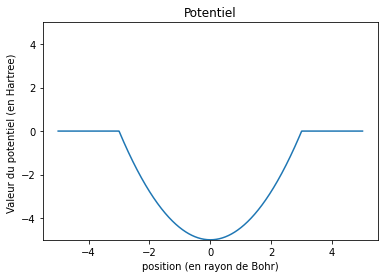

In [137]:
#CONTIENT LA PLAGE DES VALEURS DE X UTILES ET LE POTENTIEL. TRACE LE POTENTIEL.
V=V5               #potentiel utilisé
x_m=-5             #valeur minimale des abscisses         (valeur typique:dépend du potentiel)
x_M=5              #valeur maximale des abscisses         (valeur typique:dépend du potentiel)
dx=10**(-2)        #pas de la discrétisation de l'espace  (valeur typique:0.01)
x_range = np.linspace(x_m,x_M,int((x_M-x_m)/dx))
plt.figure()
plt.title("Potentiel")
plt.xlabel("position (en rayon de Bohr)")
plt.ylabel("Valeur du potentiel (en Hartree) ")
plt.plot(x_range,V(x_range))
plt.ylim(-5,5) #intervalle de l'ordonnée à afficher

RECHERCHE LINEAIRE:


  0%|          | 0/251 [00:00<?, ?it/s]


 
 AUGMENTATION DE LA PRECISION DES ENERGIES:


  0%|          | 0/5 [00:00<?, ?it/s]

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 1:


  0%|          | 0/5 [00:00<?, ?it/s]

-4.48 ===> -4.4729616666666665
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 2:


  0%|          | 0/5 [00:00<?, ?it/s]

-3.42 ===> -3.419047222222222
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 3:


  0%|          | 0/5 [00:00<?, ?it/s]

-2.36 ===> -2.366912777777778
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 4:


  0%|          | 0/5 [00:00<?, ?it/s]

-1.3199999999999998 ===> -1.3269338888888886
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 5:


  0%|          | 0/5 [00:00<?, ?it/s]

-0.3600000000000003 ===> -0.35146944444444483
 



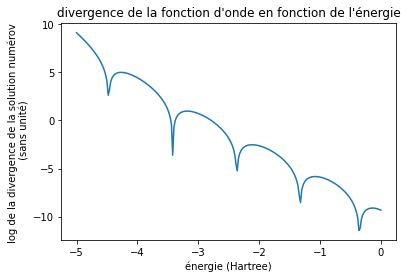

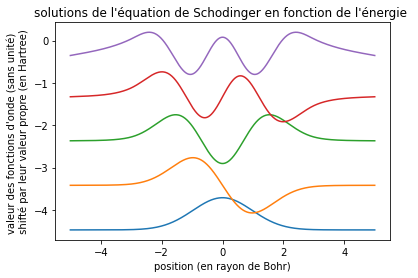

In [138]:
#CONTIENT LA VALEUR DE LA PREMIERE DERIVEE, LA PLAGE D'ENERGIE A TESTER, LE PAS D'ENERGIE POUR LA RECHERCHE LINEAIRE ET LES PARAMETRES DE LA DICHOTOMIE
eps=10**(-5)    #valeur de la première dérivée en x_m                                       (valeur typique:10**(-5))
E_min=-5        # minimum de la plage de valeurs attendue de l'énergie                      (valeur typique:dépend du potentiel)
E_max=0         # maximum de la plage de valeurs attendue de l'énergie                      (valeur typique:dépend du potentiel)
dE=0.02         # pas de l'énergie qui sera testé lors du premier crible linéaire d'énergie (valeur typique:0.02)
sens=-1         # +1= condition initiale posée en x_m;  -1= condition initiale posée en x_M
Nb_passage=5    #nombre de passage de la dichotomie effectués                                (valeur typique:10)
It_passage=10   #nombre d'iterations effectuées à chaque passage de la dichotomie            (valeur typique:20)
zoom=10         # valeur de l'augmentation de precision entre chaque passage de la dichotomie (valeur typique:10)
delta_E=0.1     #étendue de recherche de l'énergie autour de E_ini lors de la dichotomie     (valeur typique:0.1)
affiche="y"     # y= affiche le résultat de la recherche linéaire, autre sinon
recherche(V,E_min,E_max,dE,sens,x_range,Nb_passage,It_passage,zoom,delta_E,eps*dx,affiche)